In [1]:
## Requerimientos
## tf.__version__ que sea 2.6.2

# !pip  install transformers==4.5.1 -q

# CUDA
# Cuda compilation tools, release 11.2, V11.2.67
# Build cuda_11.2.r11.2/compiler.29373293_0
# Python 3.7.1

In [2]:
!python --version

Python 3.7.2


In [3]:
import tensorflow as tf

In [4]:
import numpy as np
np.version.version

'1.21.6'

In [5]:
import transformers

C:\Users\MSVF9\anaconda3\envs\ultima_cosa2_UNIR\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import numpy as np
print(np.__version__)

1.21.6


In [7]:
import pandas as pd

In [8]:
import tensorflow as tf
import keras
import pandas as pd
import json
import gc

import numpy as np

from tqdm import tqdm

from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers.utils import logging

#from transformers import TextClassificationPipeline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import re
    
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot

import random

Cerciorarse que estemos usando el GPU, debemos tener cuda instalado

In [9]:
physical_devices = tf.config.list_physical_devices('GPU')

print("GPU:", tf.config.list_physical_devices('GPU'))
print("Num GPUs:", len(physical_devices))

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs: 1


In [10]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3161052996923587620
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9855565824
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6434251314805805133
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


In [11]:
tf.sysconfig.get_build_info()['cuda_version']

'64_112'

In [12]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
!conda env

usage: conda-script.py env [-h] command ...

positional arguments:
  command
    config    Configure a conda environment.
    create    Create an environment based on an environment definition file.
    export    Export a given environment
    list      An alias for `conda info --envs`. Lists all conda environments.
    remove    Remove an environment.
    update    Update the current environment based on environment file.

options:
  -h, --help  Show this help message and exit.


In [14]:
cd F:\Maestria\TESIS\

F:\Maestria\TESIS


In [15]:
df= pd.read_csv('./BD_POL/data_extended.csv')
df.head()

,Unnamed: 0,full_text,POS,clean_text,label,text_changed
0,0,"Sin ser fan de Juan Gabriel, siempre supe que ...",P,fan juan gabriel supe fuerza naturaleza escuch...,2,fan juan gabriel supe naturaleza escuche quer...
1,1,Sabes que no tendrás un buen día cuando lo pri...,N,tendras ana tratar cambiar foco cae cara,0,tendras ana tratar cambiar foco cae caradura
2,2,"En situaciones en las que no sepas que hacer, ...",N,situaciones sepas sumergete podras escuchar al...,0,situaciones situaciones sepas sumergete podra...
3,3,ayer preguntaban y dónde están las solteras!!!...,NEU,preguntaban solteras grupo alza mano unica vol...,1,preguntaban solteras grupo alza alza alza man...
4,4,Que el finde sea para hacer cualquier cosa que...,NEU,finde cosa haga feliz reverenda gana,1,finde elemento haga feliz reverenda gana


In [16]:
df.shape

(36211, 6)

### Limpieza

In [17]:
df_w = df[["label", "text_changed"]]

In [18]:
df_w['text_changed'] = df_w['text_changed'].str.lower()

C:\Users\MSVF9\anaconda3\envs\ultima_cosa2_UNIR\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [19]:
"""Removemos los duplicados si los hubiera:"""

df_w.drop_duplicates(inplace=True)
df_w.shape

C:\Users\MSVF9\anaconda3\envs\ultima_cosa2_UNIR\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(35438, 2)

In [20]:
df_w.isna().sum()

label           0
text_changed    3
dtype: int64

In [21]:
df_w = df_w.dropna()

In [22]:
df_w.isna().sum()

label           0
text_changed    0
dtype: int64

In [23]:
df_w["text_changed"] = df_w["text_changed"].str.replace(r'\s*https?://\S+(\s+|$)', ' ').str.strip()

C:\Users\MSVF9\anaconda3\envs\ultima_cosa2_UNIR\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

The default value of regex will change from True to False in a future version.



In [24]:
df_w['text_changed'] = df_w['text_changed'].str.replace(
    r'[^a-z0-9\s]',
    '',
    regex=True,
    flags=re.IGNORECASE
)

Observamos un poco de CLASS_IMBALANCE

<Figure size 800x800 with 0 Axes>

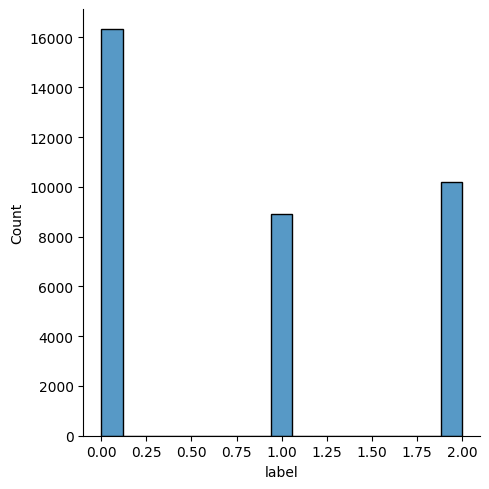

In [25]:
plt.figure(figsize= (8, 8))
sns.displot(df_w['label'])
plt.show()

In [26]:
df_w.shape

(35435, 2)

### Label Encode

In [27]:
df_w = df_w.sample(frac=1, random_state = 1) 
df_w = df_w[:20000]

In [28]:
encoder = LabelEncoder()

df_w["label"] = encoder.fit_transform(df_w["label"])
df_w.head(4)
# encoder.classes_  ## 0 neutral, 1 partisan

,label,text_changed
35227,0,dejara seguir trabajando pais elpartidomorado...
21987,0,ojala princesa ponga triste porq abuela elvira...
30264,1,candidato congreso congreso congreso alianza ...
70,0,intensiones descubro plano entra base entrega


<Figure size 800x800 with 0 Axes>

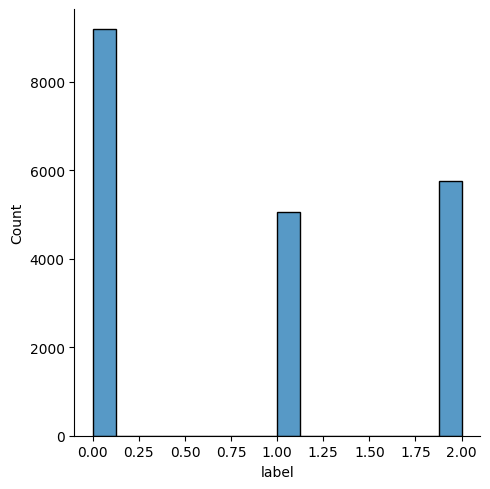

In [29]:
plt.figure(figsize= (8, 8))
sns.displot(df_w['label'])
plt.show()

In [30]:
data_texts = df_w['text_changed'].to_list()

data_labels = df_w['label'].to_list()

In [33]:
len(data_texts)

20000

In [34]:
type(data_labels)

list

### Train Test Split

In [35]:
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts,
                                                                    data_labels,
                                                                    test_size = 0.2,
                                                                    random_state = 42,  ## Shuffle
                                                                    stratify = data_labels)

val_texts, test_texts, val_labels, test_labels = train_test_split(val_texts,
                                                                  val_labels,
                                                                  test_size = 0.4,
                                                                  random_state = 42,  ## Shuffle del dS
                                                                  stratify = val_labels )

In [36]:
type(train_texts)

list

In [37]:
train_texts[0]

'novio fiesta quiero dependiente  conmigo'

## TOKENIZAR

In [38]:
# wget https://users.dcc.uchile.cl/~jperez/beto/cased_2M/pytorch_weights.tar.gz
# wget https://users.dcc.uchile.cl/~jperez/beto/cased_2M/vocab.txt
# wget https://users.dcc.uchile.cl/~jperez/beto/cased_2M/config.json
# tar -xzvf pytorch_weights.tar.gz
# mv config.json pytorch/.
# mv vocab.txt pytorch/.

In [39]:
## Usamos DISTILBERT para tokenizar el DS
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

# # Load model directly
# import torch
# from transformers import BertModel, BertTokenizer, BertConfig

# model_name = 'dccuchile/bert-base-spanish-wwm-uncased'
# tokenizer = BertTokenizer.from_pretrained(model_name)
# model = BertModel.from_pretrained(model_name)
# config = BertConfig.from_pretrained(model_name)
# print (config)


# import torch
# from transformers import BertForMaskedLM, BertTokenizer

# tokenizer = BertTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased", do_lower_case=False)
# model = BertForMaskedLM.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")
# e = model.eval()

## Tokenizamos los Datasets
train_encodings = tokenizer(train_texts, truncation = True, padding = True )
val_encodings = tokenizer(val_texts, truncation = True, padding = True )
test_encodings = tokenizer(test_texts, truncation = True, padding = True )

#### Convertimos a tensores

In [40]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))

### Hacemos el Fine-tuning con el TFTrainer class

In [41]:
from transformers import TFTrainer, TFTrainingArguments

https://discuss.huggingface.co/t/import-error-while-loading-a-fine-tuned-distilbert-model/28615

In [ ]:
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import optuna

# Cargar el modelo DistilBERT pre-entrenado
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-multilingual-cased', num_labels = 3)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

def objective(trial):
    # Definir los hiperparámetros a ajustar
    learning_rate = trial.suggest_float('learning_rate', 0.00044, 0.0005)
    batch_size = trial.suggest_int('batch_size', 64, 72)
    num_epochs = trial.suggest_int('num_epochs', 5, 6)
    
    # Preparar los datos de entrenamiento y validación
    train_dataset = prepare_dataset(train_texts, train_labels, tokenizer, batch_size)
    val_dataset = prepare_dataset(val_texts, val_labels, tokenizer, batch_size)

    # Configurar el modelo y el entrenamiento
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    # Entrenar el modelo
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=num_epochs,
        verbose=0
    )

    # y_val_pred = tf.argmax(model.predict(val_dataset), axis=1)
    # accuracy = accuracy_score(y_val, y_val_pred)
    # precision = precision_score(y_val, y_val_pred, average='macro')
    # recall = recall_score(y_val, y_val_pred, average='macro')
    # f1 = f1_score(y_val, y_val_pred, average='macro')
    
    # # Definir una función objetivo que combine las métricas
    # objective_value = 0.4 * accuracy + 0.2 * precision + 0.2 * recall + 0.2 * f1
    
    # return objective_value, accuracy, precision, recall, f1
    
    # Devolver la métrica de validación a optimizar
    return history.history['val_accuracy'][-1]

def prepare_dataset(X, y, tokenizer, batch_size):
    # Preparar los datos de entrada para el modelo DistilBERT

    # # Shuffle (tipo cross validation)
    # combined = list(zip(X, y))
    # print(type(combined))

    # # Shuffle the combined list
    # random.shuffle(combined)
    
    # # Unpack the shuffled tuples back into separate lists
    # X, y = zip(*combined)
    
    input_ids = [tokenizer.encode(text, padding='max_length', max_length=128, truncation=True) for text in X]
    dataset = tf.data.Dataset.from_tensor_slices((input_ids, y))
    dataset = dataset.batch(batch_size)
    return dataset

# Crear el estudio de Optuna y optimizar los hiperparámetros
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2)

# Obtener los mejores hiperparámetros
best_params = study.best_params
print(f'Mejores hiperparámetros: {best_params}')

# Entrenar el modelo final con los mejores hiperparámetros
final_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
final_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
final_model.fit(
    prepare_dataset(train_texts, train_labels, tokenizer, best_params['batch_size']),
    validation_data=prepare_dataset(val_texts, val_labels, tokenizer, best_params['batch_size']),
    epochs=best_params['num_epochs'],
    verbose=1
)

Some layers from the model checkpoint at distilbert-base-multilingual-cased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_39']
You should probably TRAIN this model on a down-stream ta

[I 2025-09-06 13:15:59,765] Trial 0 finished with value: 0.4595833420753479 and parameters: {'learning_rate': 0.0004546364459087497, 'batch_size': 71, 'num_epochs': 5}. Best is trial 0 with value: 0.4595833420753479.



EL mejor TRIAL:
Trial 0 finished with value: 0.8108333349227905 and parameters: {'learning_rate': 0.0005018111693642504, 'batch_size': 18, 'num_epochs': 32}. Best is trial 0 with value: 0.8108333349227905.

[I 2025-09-05 02:42:52,703] Trial 1 finished with value: 0.8700000047683716 and parameters: {'learning_rate': 0.0004639273290744141, 'batch_size': 31, 'num_epochs': 49}. Best is trial 1 with value: 0.8700000047683716.

[I 2025-09-05 02:59:39,273] Trial 2 finished with value: 0.8841666579246521 and parameters: {'learning_rate': 0.0007696840795849961, 'batch_size': 19, 'num_epochs': 35}. Best is trial 2 with value: 0.8841666579246521.




OTRO TRIAL MUCHO MEJOR

    learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.001)
    batch_size = trial.suggest_int('batch_size', 16, 32)
    num_epochs = trial.suggest_int('num_epochs', 25, 50)

[I 2025-09-05 12:50:58,154] Trial 1 finished with value: 0.9706020951271057 and parameters: {'learning_rate': 0.0005462633579365738, 'batch_size': 27, 'num_epochs': 45}. Best is trial 1 with value: 0.9706020951271057.

### Argumentos del TRAINING

In [ ]:
# 1. Define los argumentos de entrenamiento.
training_args = TFTrainingArguments(
    output_dir='./results',
    num_train_epochs=15,
    # max_steps = 40000,  # --- > Si no colocam os 400 steps, da error con el "lr_scheduler"
    per_device_train_batch_size=64,
    per_device_eval_batch_size=32,
    # warmup_steps=3500,
    weight_decay=1e-4,
    logging_dir='./logs',
    eval_steps=35, 
    # learning_rate = 0.0005462633579365738, ### 0.0005 por ah es el LR ideal al parecer
    # lr_scheduler_type = "linear"
)

# # max_steps = 500, Da error

In [ ]:
# 2. Calcula el número total de pasos de entrenamiento.
num_train_examples = int(len(train_dataset))
per_device_train_batch_size = 64
num_train_epochs = 15
num_training_steps = int((num_train_examples / per_device_train_batch_size) * num_train_epochs)

In [ ]:
from transformers import TFTrainer, TFTrainingArguments, create_optimizer

# 3. Define los warmup steps (10% del total de pasos).
num_warmup_steps = int(num_training_steps * 0.06)

# 4. Define la tasa de aprendizaje.
learning_rate = 0.0005462633579365738

# 5. Crea el optimizador con el planificador de tasa de aprendizaje.
optimizer, lr_scheduler = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_training_steps,
    num_warmup_steps=num_warmup_steps,
    adam_beta1=0.9, # Valores por defecto de Adam
    adam_beta2=0.999, # Valores por defecto de Adam
    adam_epsilon=1e-8, # Valores por defecto de Adam
    weight_decay_rate=training_args.weight_decay,
    power=1.0, # Para lr_scheduler_type="linear"
)

In [42]:
import tensorflow as tf
from tensorflow.compat.v1 import RunOptions

run_options = RunOptions(report_tensor_allocations_upon_oom=True)

In [43]:
with training_args.strategy.scope():
    trainer_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-multilingual-cased',
                                                                          num_labels = 3 )
    #trainer_model.compile(loss = "...", optimizer = "...", metrics = "..", options = run_opts)

Some layers from the model checkpoint at distilbert-base-multilingual-cased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'activation_13', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['dropout_19', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream ta

In [67]:
import evaluate

# from transformers import TFTrainerCallback
# from transformers.trainer_callback import EarlyStoppingCallback

# Crea una instancia del callback de Early Stopping
# Monitoreamos el 'eval_loss' por defecto.
# Si la pérdida no mejora en 5 pasos de evaluación, el entrenamiento se detiene.
# early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=5)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Si quieres monitorear otra métrica como 'accuracy',
# necesitas pasarla en el argumento `metric_for_best_model` en `TFTrainingArguments`
# y asegurarte de que tu función `compute_metrics` la devuelva.

# Paso 1: Tu función de métricas (la misma que ya tienes)
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     predicted_class_ids = np.argmax(predictions, axis=1)
    
#     accuracy = accuracy_metric.compute(predictions=predicted_class_ids, references=labels)
#     f1 = f1_metric.compute(predictions=predicted_class_ids, references=labels, average="weighted")
#     precision = precision_metric.compute(predictions=predicted_class_ids, references=labels, average="weighted")
#     recall = recall_metric.compute(predictions=predicted_class_ids, references=labels, average="weighted")

#     return {
#         "accuracy": accuracy["accuracy"],
#         "f1": f1["f1"],
#         "precision": precision["precision"],
#         "recall": recall["recall"],
#     }

# # Paso 2 y 3: Crea el callback personalizado
# class MyMetricsCallback(TFTrainerCallback):
#     def on_evaluate(self, args, state, control, **kwargs):
#         # El Trainer ya calculó las predicciones, las extraemos de los kwargs
#         predictions = kwargs['eval_predictions']
        
#         # Obtenemos las etiquetas reales del eval_dataset
#         labels = [item[1] for item in kwargs['eval_dataloader']]
        
#         # Preparamos el formato para nuestra función de métricas
#         eval_pred = (predictions, np.array(labels))
        
#         # Calculamos las métricas
#         metrics = compute_metrics(eval_pred)
        
#         # Imprimimos las métricas
#         print(f"\n***** Evaluation metrics at step {state.global_step} *****")
#         for key, value in metrics.items():
#             print(f"{key}: {value:.4f}")
#         print("********************************************************")

In [44]:
trainer = TFTrainer(
    model=trainer_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    optimizers=(optimizer, lr_scheduler),
    #metric_for_best_model=["accuracy"],
    #callbacks=[early_stopping_callback], # Pasa tu callback aquí
)

C:\Users\MSVF9\anaconda3\envs\ultima_cosa2_UNIR\lib\site-packages\transformers\trainer_tf.py:114: FutureWarning:

The class `TFTrainer` is deprecated and will be removed in version 5 of Transformers. We recommend using native Keras instead, by calling methods like `fit()` and `predict()` directly on the model object. Detailed examples of the Keras style can be found in our examples at https://github.com/huggingface/transformers/tree/master/examples/tensorflow

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: msvf96 (msvf96-universidad-nacional-de-san-agustin-de-arequipa). Use `wandb login --relogin` to force relogin


In [45]:
# trainer.optimizer = tf.keras.optimizers.SGD()
# trainer.optimizer = tf.keras.optimizers.Adam()
# trainer.loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)  # nuevo

In [46]:
logging.set_verbosity_info()
logger = logging.get_logger("transformers")
logger.info("INFO")
logger.warning("WARN")

INFO
WARN


In [47]:
trainer.train()

# Opcional: Para cargar el mejor modelo si el Trainer no lo hace automáticamente
# best_model_checkpoint = trainer.state.best_model_checkpoint
# if best_model_checkpoint:
#     best_model = TFDistilBertForSequenceClassification.from_pretrained(best_model_checkpoint)
#     print(f"Loaded the best model from: {best_model_checkpoint}")
# else:
#     best_model = trainer.model
#     print("No best model checkpoint found, using the final model.")

# # Guarda el mejor modelo para su uso posterior
# best_model.save_pretrained("./best_distilbert_model_1")

Checkpoint file ./results\checkpoint\ckpt-94 found and restoring from checkpoint
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 188
  Continuing training from global step 47000
  Will skip the first 0 steps in the first epoch
***** Running training *****
  Num examples = 16000
  Num Epochs = 30.0
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Steps per epoch = 250
  Total optimization steps = 7500
Training took: 0:00:00


In [75]:
# Evaluamos
# Eval_loss sale bastante grande
trainer.evaluate(val_dataset)

***** Running Evaluation *****
  Num examples in dataset = 4252
  Num examples in used in evaluation = 4256
  Batch size = 32


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


{'eval_loss': 1.0627209656220629, 'epoch': 0, 'step': 47000}


{'eval_loss': 1.0627209656220629}

In [77]:
# Asumiendo que ya tienes un 'test_dataset' preparado
test_results = trainer.evaluate(test_dataset)

# Imprime las métricas
print(test_results)

***** Running Evaluation *****
  Num examples in dataset = 2835
  Num examples in used in evaluation = 2848
  Batch size = 32


{'eval_loss': 1.0619936310843137, 'epoch': 0, 'step': 47000}


{'eval_loss': 1.0619936310843137}


#### Guardamos el modelo

In [48]:
# Define la ruta donde quieres guardar el modelo
model_save_path = "./distilbert_modelo_final_1"

# Guarda el modelo en la ruta especificada
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

Saving model in ./distilbert_modelo_final_1
Configuration saved in ./distilbert_modelo_final_1\config.json
Model weights saved in ./distilbert_modelo_final_1\tf_model.h5
tokenizer config file saved in ./distilbert_modelo_final_1\tokenizer_config.json
Special tokens file saved in ./distilbert_modelo_final_1\special_tokens_map.json


('./distilbert_modelo_final_1\\tokenizer_config.json',
 './distilbert_modelo_final_1\\special_tokens_map.json',
 './distilbert_modelo_final_1\\vocab.txt',
 './distilbert_modelo_final_1\\added_tokens.json')

#### Cargamos el modelo fine-tuned

In [49]:
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
model_save_path = "/distilbert_modelo_final_1"
# Load the tokenizer
loaded_tokenizer = DistilBertTokenizer.from_pretrained(model_save_path)
# Load the trained model
loaded_model = TFDistilBertForSequenceClassification.from_pretrained(model_save_path)

Didn't find file /distilbert_modelo_final_1\added_tokens.json. We won't load it.
loading file /distilbert_modelo_final_1\vocab.txt
loading file None
loading file /distilbert_modelo_final_1\special_tokens_map.json
loading file /distilbert_modelo_final_1\tokenizer_config.json
loading file /distilbert_modelo_final_1\tokenizer.json
loading configuration file /distilbert_modelo_final_1\config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-multilingual-cased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 

### Predecimos

In [50]:

# ## Para cargar nos ubicamos en la carpeta
# cd F:\Maestria\TESIS\





In [51]:
# save_directory = "GUARDADO/"

# tokenizer_fine_tuned = DistilBertTokenizer.from_pretrained(save_directory)

# model_fine_tuned = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

In [52]:
## Tokeznizar y tensorizar en un proceso
Lista_tensores = []

for i in range(len(test_texts)):
    predict_input = loaded_tokenizer.encode(
        test_texts[i],
        truncation = True,
        padding = True,
        return_tensors = 'tf'
    )
    Lista_tensores.append(predict_input)

In [53]:
Lista_tensores

[<tf.Tensor: shape=(1, 32), dtype=int32, numpy=
 array([[   101,  10173,  77993,  10840,  18089,  10107,  15928, 106350,
          89221,  96938,  10107,  53356,  10263,  10178,  10761,  38036,
          10212,  18115,  81404,  10107,  22531,  13705,  48897,  28653,
          38548,  30221,  30221,  43345,  64741,  28908,  34046,    102]])>,
 <tf.Tensor: shape=(1, 12), dtype=int32, numpy=
 array([[   101,  10114, 102927,    177,  10350,  51538, 101986,  31369,
          81049,  10321,  70917,    102]])>,
 <tf.Tensor: shape=(1, 16), dtype=int32, numpy=
 array([[  101, 30423, 10173, 77993, 56094, 56094, 88333, 40838, 10178,
         10138, 74720, 49167, 25130, 10288, 27982,   102]])>,
 <tf.Tensor: shape=(1, 23), dtype=int32, numpy=
 array([[   101,  11284,  76560,  10835,  71115,  12333,    184,  10637,
          20763,    184,  10637,  15392,  16942,  13784, 102072,  10113,
          16942,  13784, 102072,  10113,  71720,  10133,    102]])>,
 <tf.Tensor: shape=(1, 45), dtype=int32, nump

In [54]:
lista_predichos = []
for i in range(len(Lista_tensores)):
    test_pred = loaded_model.predict(Lista_tensores[i])
    lista_predichos.append(test_pred)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [55]:
lista_predicho_label = []

for i in range(len(lista_predichos)):
    prediction_values = tf.argmax(lista_predichos[i][0], axis = 1).numpy()[0]
    
    lista_predicho_label.append(prediction_values)

In [56]:
print(lista_predicho_label)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### Matriz de Confusion

[[735   0   0]
 [405   0   0]
 [460   0   0]]


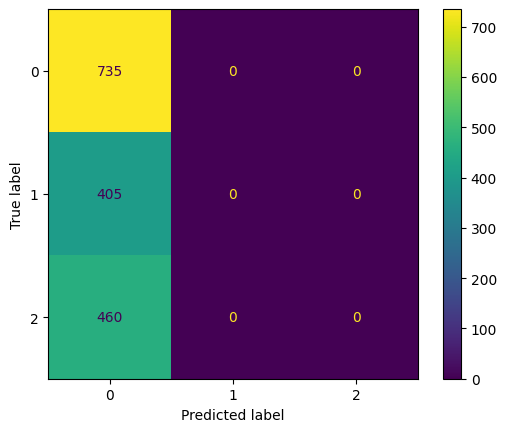

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy

# Create a confusion matrix
conf_mat = confusion_matrix(test_labels, lista_predicho_label)

# Print the confusion matrix
print(conf_mat)

confusion_matrix = confusion_matrix(test_labels, lista_predicho_label)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

In [58]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate the metrics
accuracy = accuracy_score(test_labels, lista_predicho_label)
precision = precision_score(test_labels, lista_predicho_label, average='macro')
recall = recall_score(test_labels, lista_predicho_label, average='macro')
f1 = f1_score(test_labels, lista_predicho_label, average='macro')

# Print the metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

Accuracy: 0.459
Precision: 0.153
Recall: 0.333
F1 score: 0.210


C:\Users\MSVF9\anaconda3\envs\ultima_cosa2_UNIR\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### Explicar con SHAP

In [ ]:
import shap

In [ ]:
linea_ = "i hate donald trump" 
linea_2 = "we need free healthcare or we are going to die" 

predict_input_1 = tokenizer_fine_tuned.encode(
    linea_,
    truncation = True,
    padding = True,
    return_tensors = 'tf'
)

predict_input_2 = tokenizer_fine_tuned.encode(
    linea_2,
    truncation = True,
    padding = True,
    return_tensors = 'tf'
)

In [ ]:
output_1 = model_fine_tuned(predict_input_1)[0]

prediction_value_1 = tf.argmax(output_1, axis = 1).numpy()[0]
print(linea_)
prediction_value_1

# 0  es Partisan 

In [ ]:
output_2 = model_fine_tuned(predict_input_2)[0]

prediction_value_2 = tf.argmax(output_2, axis = 1).numpy()[0]
print(linea_2)
prediction_value_2
# 1 es NEUTRO

Textos a usar son los textos que obtuvieron un score significativo

In [ ]:
textos_para_shap = []
for i in lista_v2:
    texto_para_shap = test_texts[i]
    textos_para_shap.append(texto_para_shap)

In [ ]:
# textos_para_shap

In [ ]:
from transformers import (AutoTokenizer, 
                          AutoModelForSequenceClassification, 
                          TextClassificationPipeline)

pipe = TextClassificationPipeline(model=model_fine_tuned, tokenizer=tokenizer_fine_tuned, return_all_scores=True)

In [ ]:
##############################################

In [ ]:
## Añadir el codigo porque SHAP funciona mejor con "aditive values"
# pmodel = shap.models.TransformersPipeline(pipe, rescale_to_logits=True)

In [ ]:
##############################################

In [1]:
# explainer = shap.Explainer(pipe)
# shap_values = explainer(textos_para_shap)

 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:16<00:00, 22.35it/s]
500it [00:16, 22.47it/s]                                                                                               
504it [00:17, 21.10it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:13<00:00, 25.32it/s]
500it [00:14, 25.51it/s]                                                                                               
504it [00:14, 23.85it/s]
 82%|█████████████████████████████████████████████████████████████████▊              | 410/498 [00:09<00:03, 27.49it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:24<00:00, 16.12it/s]
500it [00:24, 16.16it/s]                                                                                               
504it [00:25, 15.74it/s]
 82%|█████████████████████████████████████████████████████████████████▊              | 410/498 [00:19<00:05, 16.07it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:25<00:00, 16.02it/s]
500it [00:25, 15.91it/s]                                                                                               
504it [00:25, 15.67it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:13<00:00, 26.27it/s]
500it [00:13, 26.28it/s]                                                                                               
504it [00:13, 24.40it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:16<00:00, 22.29it/s]
500it [00:16, 22.07it/s]                                                                                               
504it [00:17, 20.87it/s]
 86%|████████████████████████████████████████████████████████████████████▊           | 428/498 [00:09<00:02, 28.27it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:22<00:00, 17.28it/s]
500it [00:23, 17.33it/s]                                                                                               
504it [00:23, 16.90it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:25<00:00, 14.74it/s]


500it [00:26, 14.81it/s]                                                                                               
504it [00:26, 14.32it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:18<00:00, 20.19it/s]
500it [00:19, 20.05it/s]                                                                                               
504it [00:19, 18.69it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:17<00:00, 21.37it/s]
500it [00:18, 21.19it/s]                                                                                               
504it [00:18, 19.68it/s]
 47%|█████████████████████████████████████▉                                          | 236/498 [00:06<00:11, 22.78it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:19<00:00, 20.02it/s]
500it [00:19, 20.11it/s]                                                                                               
504it [00:19, 18.55it/s]
 58%|██████████████████████████████████████████████▌                                 | 290/498 [00:09<00:10, 19.56it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:19<00:00, 19.65it/s]
500it [00:20, 19.58it/s]                                                                                               
504it [00:20, 18.20it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:16<00:00, 22.24it/s]
500it [00:17, 21.87it/s]                                                                                               
504it [00:17, 17.11it/s]
 63%|██████████████████████████████████████████████████▍                             | 314/498 [00:08<00:07, 23.61it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:15<00:00, 23.06it/s]
500it [00:16, 23.25it/s]                                                                                               
504it [00:16, 21.84it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:15<00:00, 24.12it/s]
500it [00:15, 24.11it/s]                                                                                               
504it [00:15, 22.54it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:12<00:00, 27.29it/s]
500it [00:12, 27.21it/s]                                                                                               
504it [00:13, 25.37it/s]
 57%|█████████████████████████████████████████████▌                                  | 284/498 [00:06<00:07, 27.16it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:15<00:00, 23.73it/s]
500it [00:15, 23.98it/s]                                                                                               
504it [00:15, 22.37it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:12<00:00, 27.28it/s]
500it [00:12, 27.32it/s]                                                                                               
504it [00:12, 25.51it/s]
 70%|████████████████████████████████████████████████████████▏                       | 350/498 [00:08<00:06, 24.56it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:14<00:00, 24.62it/s]
500it [00:14, 24.86it/s]                                                                                               
504it [00:15, 23.25it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:14<00:00, 25.25it/s]
500it [00:14, 25.43it/s]                                                                                               
504it [00:14, 23.70it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:13<00:00, 26.11it/s]
500it [00:13, 25.77it/s]                                                                                               
504it [00:14, 24.18it/s]
 59%|███████████████████████████████████████████████▌                                | 296/498 [00:06<00:07, 26.21it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:15<00:00, 23.83it/s]
500it [00:15, 23.46it/s]                                                                                               
504it [00:15, 21.93it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:16<00:00, 22.67it/s]
500it [00:16, 22.74it/s]                                                                                               
504it [00:16, 21.11it/s]
 81%|████████████████████████████████████████████████████████████████▊               | 374/462 [00:07<00:02, 30.51it/s]


100%|███████████████████████████████████████████████████████████████████████████████▋| 496/498 [00:12<00:00, 25.96it/s]
502it [00:13, 26.47it/s]                                                                                               
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:16<00:00, 22.93it/s]
500it [00:16, 22.69it/s]                                                                                               
504it [00:16, 21.33it/s]
 52%|█████████████████████████████████████████▊                                      | 260/498 [00:14<00:18, 13.06it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:32<00:00, 13.01it/s]
500it [00:32, 12.97it/s]                                                                                               
504it [00:33, 12.39it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:13<00:00, 25.93it/s]
500it [00:13, 25.91it/s]                                                                                               
504it [00:14, 24.05it/s]
 98%|██████████████████████████████████████████████████████████████████████████████▍ | 488/498 [00:14<00:00, 24.26it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:14<00:00, 24.36it/s]
500it [00:14, 24.10it/s]                                                                                               
504it [00:15, 22.67it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:12<00:00, 26.91it/s]
500it [00:13, 26.70it/s]                                                                                               
504it [00:13, 24.81it/s]
 85%|███████████████████████████████████████████████████████████████████▊            | 422/498 [00:18<00:04, 17.39it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:22<00:00, 17.60it/s]
500it [00:22, 17.74it/s]                                                                                               
504it [00:22, 17.26it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:15<00:00, 23.50it/s]
500it [00:15, 23.65it/s]                                                                                               
504it [00:15, 21.95it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:14<00:00, 25.11it/s]
500it [00:14, 25.20it/s]                                                                                               
504it [00:14, 23.57it/s]
 57%|█████████████████████████████████████████████▌                                  | 284/498 [00:05<00:05, 36.97it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:13<00:00, 24.89it/s]
500it [00:13, 25.14it/s]                                                                                               
504it [00:14, 23.20it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:15<00:00, 22.36it/s]
500it [00:15, 22.17it/s]                                                                                               
504it [00:16, 20.63it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:16<00:00, 22.57it/s]
500it [00:16, 22.59it/s]                                                                                               
504it [00:17, 20.81it/s]
  0%|                                                                                          | 0/462 [00:00<?, ?it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:17<00:00, 21.82it/s]
500it [00:17, 21.89it/s]                                                                                               
504it [00:17, 20.33it/s]
 96%|████████████████████████████████████████████████████████████████████████████▋   | 230/240 [00:03<00:00, 47.24it/s]
248it [00:04, 41.63it/s]                                                                                               
 80%|███████████████████████████████████████████████████████████████▉                | 398/498 [00:13<00:04, 21.18it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:17<00:00, 21.37it/s]
500it [00:18, 21.23it/s]                                                                                               
504it [00:18, 19.77it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:31<00:00, 13.26it/s]
500it [00:32, 13.23it/s]                                                                                               
504it [00:32, 13.00it/s]
 44%|███████████████████████████████████                                             | 218/498 [00:05<00:10, 26.83it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:18<00:00, 20.36it/s]
500it [00:19, 20.39it/s]                                                                                               
504it [00:19, 18.98it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:17<00:00, 21.23it/s]
500it [00:18, 21.27it/s]                                                                                               
504it [00:18, 19.75it/s]
 71%|█████████████████████████████████████████████████████████▏                      | 356/498 [00:10<00:06, 23.04it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:21<00:00, 18.30it/s]
500it [00:21, 18.32it/s]                                                                                               
504it [00:21, 17.10it/s]
 97%|█████████████████████████████████████████████████████████████████████████████▍  | 482/498 [00:15<00:00, 22.28it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:17<00:00, 20.99it/s]
500it [00:17, 21.17it/s]                                                                                               
504it [00:18, 19.79it/s]
 85%|███████████████████████████████████████████████████████████████████▊            | 422/498 [00:15<00:03, 20.40it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:18<00:00, 20.54it/s]
500it [00:19, 20.36it/s]                                                                                               
504it [00:19, 18.97it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:20<00:00, 18.95it/s]
500it [00:20, 18.89it/s]                                                                                               
504it [00:21, 17.56it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:19<00:00, 19.89it/s]


500it [00:19, 19.94it/s]                                                                                               
504it [00:19, 18.05it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:19<00:00, 19.62it/s]
500it [00:20, 19.56it/s]                                                                                               
504it [00:20, 18.24it/s]
 71%|█████████████████████████████████████████████████████████▏                      | 356/498 [00:10<00:06, 22.64it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:17<00:00, 22.36it/s]
500it [00:17, 22.27it/s]                                                                                               
504it [00:17, 20.62it/s]
 69%|███████████████████████████████████████████████████████▎                        | 344/498 [00:09<00:06, 22.17it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:16<00:00, 22.16it/s]
500it [00:16, 22.30it/s]                                                                                               
504it [00:17, 20.67it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:18<00:00, 20.90it/s]
500it [00:18, 21.01it/s]                                                                                               
504it [00:18, 19.45it/s]
 84%|██████████████████████████████████████████████████████████████████▊             | 416/498 [00:13<00:03, 22.13it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:17<00:00, 21.98it/s]
500it [00:17, 22.08it/s]                                                                                               
504it [00:17, 20.40it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:17<00:00, 22.19it/s]
500it [00:17, 22.25it/s]                                                                                               
504it [00:17, 20.56it/s]
 55%|███████████████████████████████████████████▋                                    | 272/498 [00:07<00:10, 20.98it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:18<00:00, 20.32it/s]
500it [00:18, 20.45it/s]                                                                                               
504it [00:19, 19.07it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:17<00:00, 21.19it/s]
500it [00:17, 21.30it/s]                                                                                               
504it [00:18, 19.52it/s]
 82%|█████████████████████████████████████████████████████████████████▊              | 410/498 [00:13<00:03, 22.14it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:17<00:00, 21.91it/s]
500it [00:17, 22.03it/s]                                                                                               
504it [00:17, 20.47it/s]
 99%|███████████████████████████████████████████████████████████████████████████████▎| 494/498 [00:16<00:00, 22.73it/s]
500it [00:16, 22.68it/s]                                                                                               
504it [00:16, 20.78it/s]
Partition explainer: 124it [37:10, 18.28s/it]                                                                          


In [ ]:
# 0 neutro / 1 partisano
print(lista_v[120])

In [ ]:
print(lista_v3[120])

In [ ]:
# En lista LABELS tenemos que poner como índice al índice que obtuvimos en lista_v, 
# porque ese índice es el índice de la predicción
# el nuevo índice va del 0 al 123, pero el antiguo va del 0 al 300+
test_labels[177]

In [ ]:
# En lista SCORES tenemos que poner como índice al índice que obtuvimos en lista_v, 
# porque ese índice es el índice de la predicción
# el nuevo índice va del 0 al 123, pero el antiguo va del 0 al 300+
lista_scores[177]
## Verificar que sea el mayor % para 1 (partisan)

In [ ]:
# shap.plots.text(shap_values)
# # shap.plots.text(shap_values[0:],num_starting_labels=0, grouping_threshold=0.1, separator='',xmin=0.2,cmax=None)


Según la librería de SHAP: "SHAP requires tensor outputs from the classifier, and explanations works best in **additive spaces** so we transform the probabilities into logit values (information values instead of probabilites)."


In [ ]:
pmodel = shap.models.TransformersPipeline(classifier, rescale_to_logits=True)


In [ ]:
# https://datascience.stackexchange.com/questions/113359/why-there-is-no-preprocessing-step-for-training-bert